from  https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

# Transfer learning with TensorFlow Hub


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Setup

In [2]:
import os, pathlib

import numpy as np
import time
import datetime
import math


import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib as mpl


os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf
import tensorflow_hub as hub

# https://github.com/tensorflow/tensorflow/issues/65419
# import tf_keras
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
    import tf_keras as keras
else:
    keras = tf.keras

from tensorflow.keras import layers

%load_ext tensorboard

2025-01-18 17:38:18.578122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737221898.597046    1298 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737221898.602378    1298 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 17:38:18.624760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [4]:
tf.config.experimental.set_memory_growth(gpus[0], enable=True)

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

In [5]:
!pwd
# ! ls -la ./../../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45
! ls -la ./../../../../../Data
! ls -la ./../../../../Data/MultiModalGenAI/resisc45
! ls -la ./../../../../../models/MultiModalGenAI/deforestation


/workspace/repos/GenerativeShift/presentations/ScienceFair/January2025
total 25266660
drwxrwxrwx 1 1000 1000        4096 Dec 16 00:24 .
drwxrwxrwx 1 1000 1000        4096 Jan 12 21:22 ..
drwxrwxrwx 1 1000 1000        4096 Dec 24 14:15 .ipynb_checkpoints
-rwxrwxrwx 1 1000 1000      227059 Nov  6 23:20 Color.jpeg
-rwxrwxrwx 1 1000 1000      132845 Nov  6 23:25 Color2.jpeg
-rwxrwxrwx 1 1000 1000        6251 Nov  3 15:02 Lena.jpeg
-rwxrwxrwx 1 1000 1000      473831 Nov 24 20:25 Lena_colored.jpeg
-rwxrwxrwx 1 1000 1000       54015 Nov  6 22:30 Mamica.jpeg
drwxrwxrwx 1 1000 1000        4096 Jan 14 00:29 MultiModalGenAI
drwxrwxrwx 1 1000 1000        4096 Sep  2 16:54 archive
-rwxrwxrwx 1 1000 1000 25872152491 Sep  2 16:29 archive.zip
ls: cannot access './../../../../Data/MultiModalGenAI/resisc45': No such file or directory
total 0
drwxrwxrwx 1 1000 1000 4096 Jan 14 00:07 .
drwxrwxrwx 1 1000 1000 4096 Jan 12 21:26 ..
drwxrwxrwx 1 1000 1000 4096 Jan 12 23:36 deforestation_model_1736724957
drwxr

In [6]:
# data_dir = './../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45'
input_data_dir = './../../../../../Data/MultiModalGenAI/resisc45/NWPU-RESISC45_small'

output_models_dir = './../../../../../models/MultiModalGenAI/deforestation'

In [7]:
dataset_path = pathlib.Path(input_data_dir).with_suffix('')
image_count = len(list(dataset_path.glob('*/*.jpg')))
print(image_count)

9100


First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [8]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_path),
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(dataset_path),
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 9100 files belonging to 13 classes.
Using 5460 files for training.


I0000 00:00:1737221917.772218    1298 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 9100 files belonging to 13 classes.
Using 3640 files for validation.


Our dataset has five classes:

In [9]:
class_names = np.array(train_ds.class_names)
print(class_names)

['beach' 'circular_farmland' 'cloud' 'desert' 'forest' 'freeway' 'lake'
 'meadow' 'mountain' 'rectangular_farmland' 'river' 'snowberg' 'wetland']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2025-01-18 17:38:54.128690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [13]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [14]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=( img_height, img_width, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [15]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

I0000 00:00:1737221937.606907    1384 cuda_dnn.cc:529] Loaded cuDNN version 90300


(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [16]:
num_classes = len(class_names)

# model = tf_keras.Sequential([
model = tf.keras.Sequential([
    feature_extractor_layer,
    # tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x)),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 13)                16653     
                                                                 
Total params: 2274637 (8.68 MB)
Trainable params: 16653 (65.05 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [17]:
predictions = model(image_batch)

In [18]:
predictions.shape

TensorShape([32, 13])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [20]:
NUM_EPOCHS = 15

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/15


I0000 00:00:1737221945.643755    1385 service.cc:148] XLA service 0x7f7ad19eeec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737221945.647791    1385 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-01-18 17:39:05.765765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737221946.170946    1385 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/171 [==============================] - 65s 350ms/step - loss: 0.7198 - acc: 0.7853 - val_loss: 0.3882 - val_acc: 0.8838
Epoch 2/15
171/171 [==============================] - 38s 224ms/step - loss: 0.3134 - acc: 0.8995 - val_loss: 0.3176 - val_acc: 0.8984
Epoch 3/15
171/171 [==============================] - 60s 350ms/step - loss: 0.2330 - acc: 0.9288 - val_loss: 0.2874 - val_acc: 0.9088
Epoch 4/15
171/171 [==============================] - 44s 259ms/step - loss: 0.1844 - acc: 0.9445 - val_loss: 0.2709 - val_acc: 0.9126
Epoch 5/15
171/171 [==============================] - 43s 254ms/step - loss: 0.1505 - acc: 0.9582 - val_loss: 0.2610 - val_acc: 0.9143
Epoch 6/15
171/171 [==============================] - 123s 720ms/step - loss: 0.1253 - acc: 0.9679 - val_loss: 0.2549 - val_acc: 0.9154
Epoch 7/15
171/171 [==============================] - 140s 820ms/step - loss: 0.1057 - acc: 0.9745 - val_loss: 0.2513 - val_acc: 0.9157
Epoch 8/15
171/171 [==============================] - 131s 770ms

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [21]:
# %tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [22]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 6s 6s/step
['rectangular_farmland' 'desert' 'desert' 'wetland' 'freeway' 'desert'
 'meadow' 'river' 'cloud' 'lake' 'freeway' 'meadow' 'desert' 'wetland'
 'wetland' 'lake' 'rectangular_farmland' 'desert' 'beach' 'wetland'
 'desert' 'snowberg' 'river' 'wetland' 'freeway' 'beach'
 'rectangular_farmland' 'lake' 'snowberg' 'cloud' 'freeway' 'cloud']


Plot the model predictions:

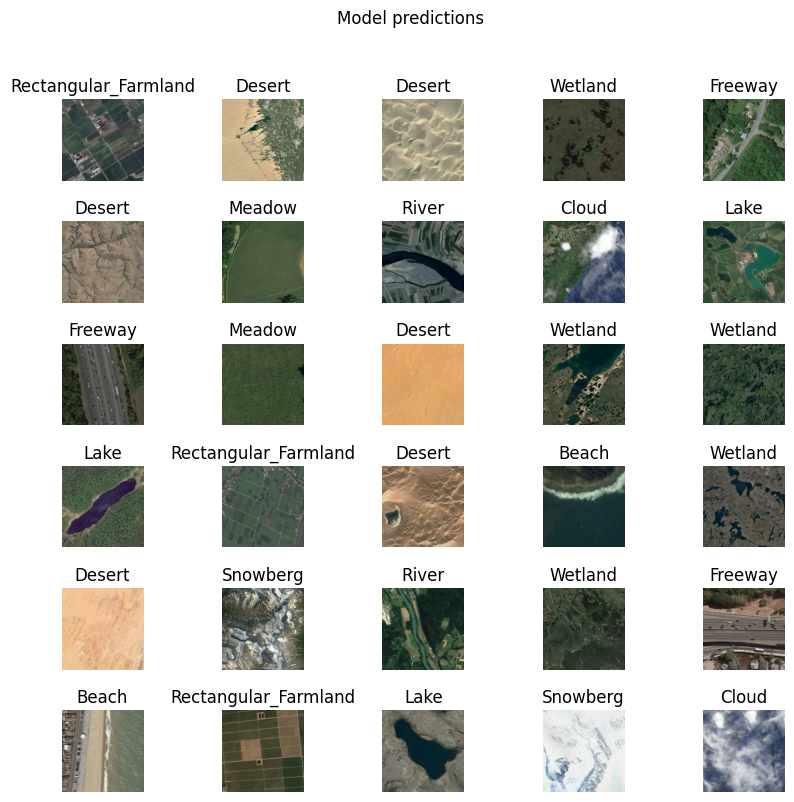

In [23]:
_ = plt.figure(figsize=(10,9))
_ = plt.subplots_adjust(hspace=0.5)

for n in range(30):
  _ = plt.subplot(6,5,n+1)
  _ = plt.imshow(image_batch[n])
  _ = plt.title(predicted_label_batch[n].title())
  _ = plt.axis('off')
_ = plt.suptitle("Model predictions")

In [24]:
for image_batch_val, labels_batch_val in val_ds:
  print(image_batch_val.shape)
  print(labels_batch_val.shape)
  break

(32, 224, 224, 3)
(32,)


In [25]:
type(labels_batch_val[n])

tensorflow.python.framework.ops.EagerTensor

In [26]:
predicted_batch_val = model.predict(image_batch_val)
predicted_id_val = tf.math.argmax(predicted_batch_val, axis=-1)
predicted_label_batch_val = class_names[predicted_id_val]
print(predicted_label_batch_val)

1/1 [==============================] - 1s 584ms/step
['snowberg' 'mountain' 'lake' 'forest' 'beach' 'river' 'snowberg'
 'mountain' 'river' 'cloud' 'wetland' 'beach' 'freeway'
 'circular_farmland' 'freeway' 'mountain' 'river' 'wetland' 'meadow'
 'river' 'river' 'meadow' 'beach' 'freeway' 'snowberg' 'forest' 'beach'
 'snowberg' 'snowberg' 'wetland' 'forest' 'desert']


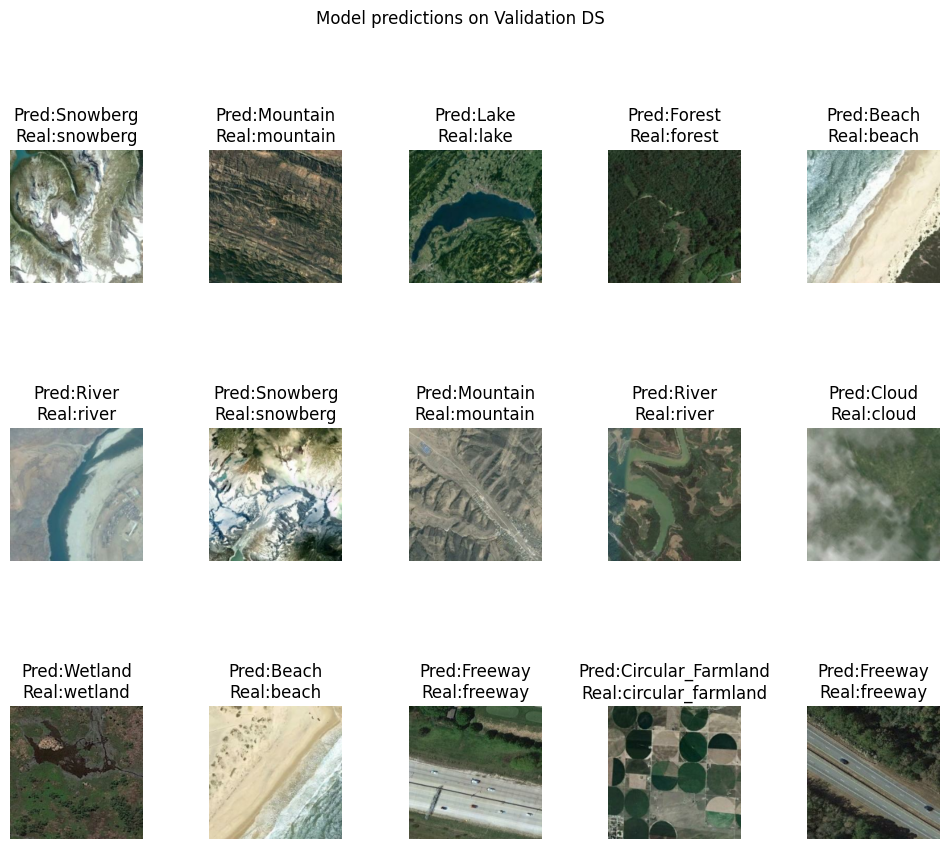

In [27]:
_ = plt.figure(figsize=(12,10))
_ = plt.subplots_adjust(hspace=0.3, wspace=.5)

for n in range(15):
  _ = plt.subplot(3,5,n+1)
  _ = plt.imshow(image_batch_val[n])
  _ = plt.title(f'Pred:{str(predicted_label_batch_val[n].title())}\nReal:{class_names[predicted_id_val[n]]}')
  _ = plt.axis('off')
_ = plt.suptitle("Model predictions on Validation DS")



In [28]:
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)
validation_labels1 = tf.concat([y for x, y in val_ds], axis=0).numpy()

2025-01-19 02:29:47.037536: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-19 02:29:47.204976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
validation_labels.shape
validation_labels1.shape

(3640,)

(3640,)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [31]:
# Predict and generate confusion matrix and classification report
prediction = model.predict(val_ds)
score = model.evaluate(val_ds, verbose=0)
validation_pred = np.argmax(prediction, axis = 1)
cm = confusion_matrix(validation_labels, validation_pred)

114/114 [==============================] - 11s 87ms/step


<Figure size 900x900 with 0 Axes>

<Axes: >

Text(83.0815972222222, 0.5, 'Actual label')

Text(0.5, 137.08159722222217, 'Predicted label')

Text(0.5, 1.0, 'Model Accuracy Score: 91.79%')

                      precision    recall  f1-score   support

               beach       0.95      0.90      0.92       282
   circular_farmland       0.98      0.98      0.98       286
               cloud       0.96      0.96      0.96       282
              desert       0.92      0.86      0.89       272
              forest       0.95      0.94      0.95       290
             freeway       0.97      0.96      0.96       293
                lake       0.85      0.86      0.85       284
              meadow       0.88      0.93      0.90       279
            mountain       0.84      0.95      0.89       270
rectangular_farmland       0.93      0.94      0.94       265
               river       0.88      0.88      0.88       283
            snowberg       0.97      0.96      0.97       281
             wetland       0.84      0.82      0.83       273

            accuracy                           0.92      3640
           macro avg       0.92      0.92      0.92      3640
      

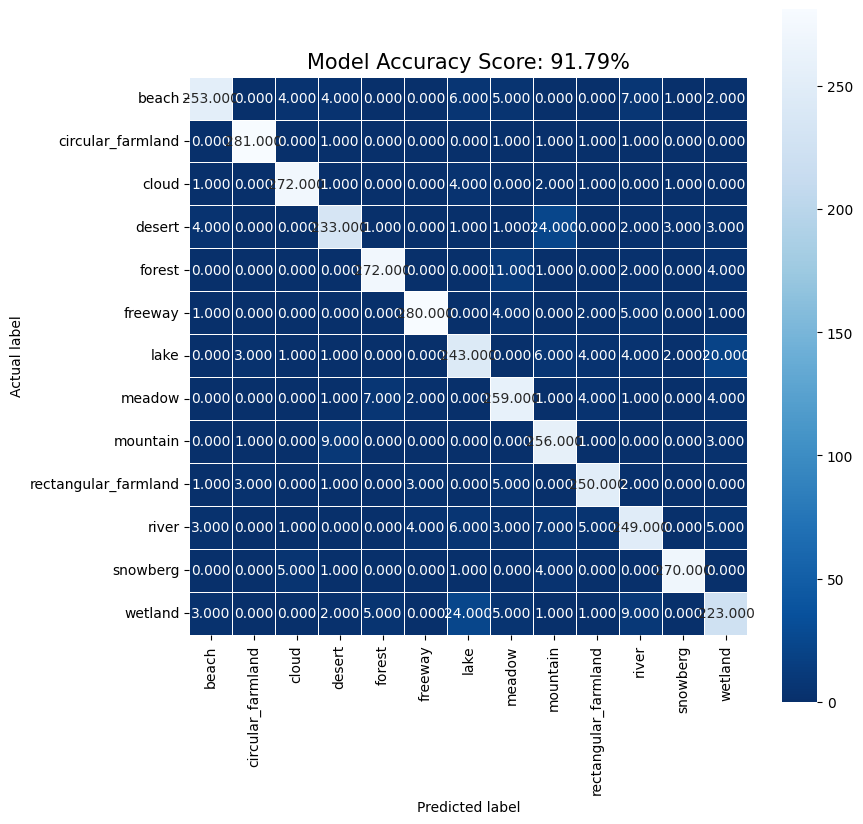

In [32]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title, size = 15)

print(classification_report(validation_labels, validation_pred, target_names=class_names))

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [33]:
t = time.time()

export_path = f'{output_models_dir}/deforestation_model_{int(time.time())}'
output_models_dir
model.save(export_path)

export_path

'./../../../../../models/MultiModalGenAI/deforestation'

INFO:tensorflow:Assets written to: ./../../../../../models/MultiModalGenAI/deforestation/deforestation_model_1737253841/assets


INFO:tensorflow:Assets written to: ./../../../../../models/MultiModalGenAI/deforestation/deforestation_model_1737253841/assets


'./../../../../../models/MultiModalGenAI/deforestation/deforestation_model_1737253841'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [34]:
reloaded = tf.keras.models.load_model(export_path)

In [35]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 1s 582ms/step


In [36]:
abs(reloaded_result_batch - result_batch).max()

np.float32(0.0)

In [37]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['rectangular_farmland' 'desert' 'desert' 'wetland' 'freeway' 'desert'
 'meadow' 'river' 'cloud' 'lake' 'freeway' 'meadow' 'desert' 'wetland'
 'wetland' 'lake' 'rectangular_farmland' 'desert' 'beach' 'wetland'
 'desert' 'snowberg' 'river' 'wetland' 'freeway' 'beach'
 'rectangular_farmland' 'lake' 'snowberg' 'cloud' 'freeway' 'cloud']


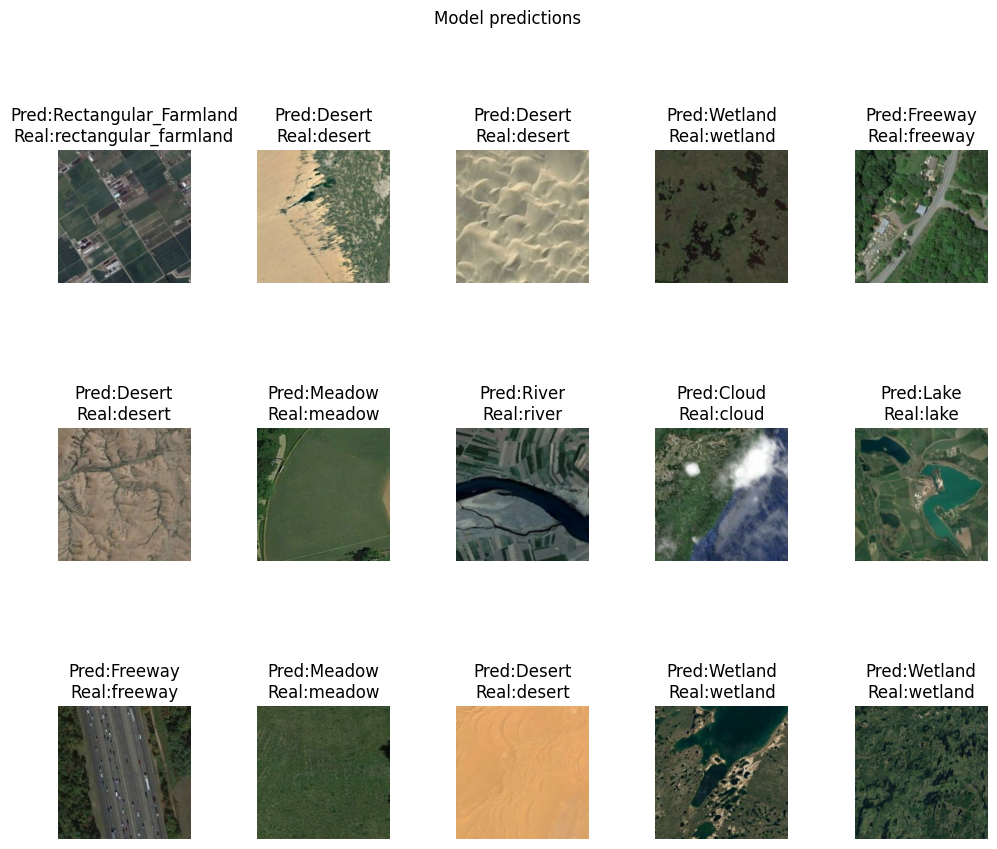

In [38]:
_ = plt.figure(figsize=(12,10))
_ = plt.subplots_adjust(hspace=0.3, wspace=.5)
for n in range(15):
    _ = plt.subplot(3,5,n+1)
    _ = plt.imshow(image_batch[n])
    _ = plt.title(reloaded_predicted_label_batch[n].title())
    _ = plt.title(f'Pred:{str(reloaded_predicted_label_batch[n].title())}\nReal:{class_names[reloaded_predicted_id[n]]}')
    _ = plt.axis('off')
    _ = plt.suptitle("Model predictions")

In [39]:
!ls -la ./../../models/MultiModalGenAI/deforestation/

ls: cannot access './../../models/MultiModalGenAI/deforestation/': No such file or directory


## Next: Patched Object Detection using transfer learning based image classification 
